Saved figure as figures/shots_vs_avgdE_h2o_color_dt.pdf


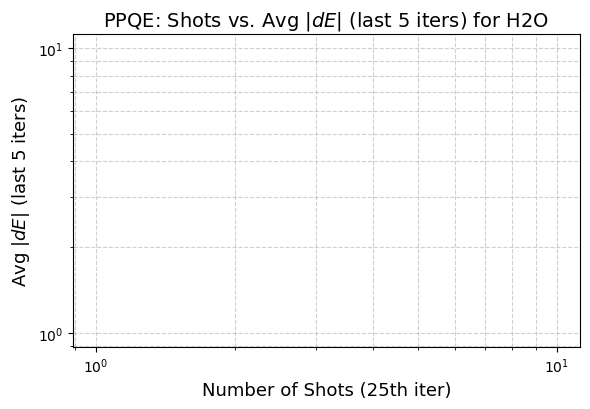

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"  # molecule string in filename

# Color palette for dt values (expand as needed)
color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
plot_update_types = ['jl', 'tlr', 'tlrim']
dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")

# --- Gather all files ---
all_files = glob.glob(f"ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize data: {dt: {update_type: {nshots: [avg_last5_dE, ...]}}} ---
data = defaultdict(lambda: {ut: defaultdict(list) for ut in plot_update_types})

for fname in all_files:
    # Parse dt, update_type
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    if not (dt_m and update_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    if update_type not in plot_update_types:
        continue

    # Read last 5 dE values (3rd column) and nshots (last column)
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    if len(lines) < 25:
        continue
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    dE = np.abs(arr[-5:, 2])
    avg_last5 = np.mean(dE)
    nshots = arr[24, -1]  # 25th iteration, last column

    data[dt][update_type][nshots].append(avg_last5)

# --- Assign a color to each dt ---
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

# --- Plot all update types on the same graph, color by dt, linestyle by update type ---
plt.figure(figsize=(6, 4.2))

for i, dt in enumerate(dt_vals):
    color = dt_to_color[dt]
    for ut in plot_update_types:
        nshots_list = sorted(data[dt][ut].keys())
        if not nshots_list:
            continue
        avg_dEs = [np.mean(data[dt][ut][n]) for n in nshots_list]
        label = f"$\Delta t$={dt:.2e}, {update_types[ut]['label']}"
        plt.plot(
            nshots_list, avg_dEs, marker='o',
            linestyle=update_types[ut]['linestyle'],
            color=color,
            label=label
        )

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Shots (25th iter)", fontsize=13)
plt.ylabel("Avg $|dE|$ (last 5 iters)", fontsize=13)
plt.title(f"PPQE: Shots vs. Avg $|dE|$ (last 5 iters) for {sys_str.upper()}", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
# plt.legend(fontsize=9, loc='best')
plt.tight_layout()

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/shots_vs_avgdE_{sys_str}_color_dt.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

Saved figure as figures/shots_vs_dE_iter20_h2o_color_dt.pdf


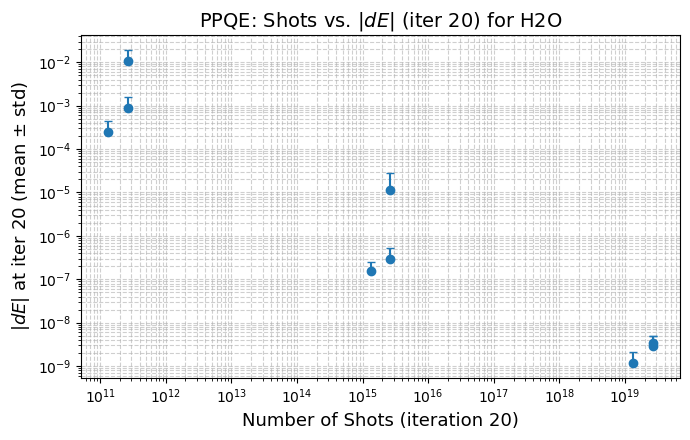

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"  # molecule string in filename
n_iter = 20      # Which PPQE iteration to analyze (1-based, e.g. 10 for 10th iter)
include_dt = [1.0e-2, 1.0e-1]  # e.g., [1.0e-3, 1.0e-2] or None for all
include_update_types = ['jl', 'tlr', 'tlrim']  # e.g., ['jl', 'tlr'] or None for all
include_noise_factors = [1.0e-8, 1.0e-6, 1.0e-4]  # e.g., [1e-3, 1e-2] or None for all


# Color palette for dt values (expand as needed)
color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
all_update_types = ['jl', 'tlr', 'tlrim']
if include_update_types is None:
    plot_update_types = all_update_types
else:
    plot_update_types = [ut for ut in include_update_types if ut in all_update_types]

dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")
noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")

# --- Gather all files ---
all_files = glob.glob(f"ppqe_noisy_runs_data/ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize data: {dt: {update_type: {noise: {nshots: [|dE|_n, ...]}}}} ---
data = defaultdict(lambda: {ut: defaultdict(lambda: defaultdict(list)) for ut in plot_update_types})

for fname in all_files:
    # Parse dt, update_type, noise
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    noise_m = noise_pattern.search(fname)
    if not (dt_m and update_m and noise_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    noise = float(noise_m.group(1))
    if include_dt is not None and dt not in include_dt:
        continue
    if update_type not in plot_update_types:
        continue
    if include_noise_factors is not None and noise not in include_noise_factors:
        continue

    # Read nth dE value (3rd column) and nshots (last column)
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    if len(lines) < n_iter:
        continue
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    dE_n = np.abs(arr[n_iter-1, 2])
    nshots_n = arr[n_iter-1, -1]
    data[dt][update_type][noise][nshots_n].append(dE_n)

# --- Assign a color to each dt ---
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

# --- Plot ---
plt.figure(figsize=(7, 4.5))

for dt in dt_vals:
    color = dt_to_color[dt]
    for ut in plot_update_types:
        for noise in sorted(data[dt][ut].keys()):
            nshots_list = sorted(data[dt][ut][noise].keys())
            if not nshots_list:
                continue
            avg_dEs = [np.mean(data[dt][ut][noise][n]) for n in nshots_list]
            std_dEs = [np.std(data[dt][ut][noise][n]) for n in nshots_list]
            label = f"$\Delta t$={dt:.2e}, {update_types[ut]['label']}, noise={noise:.1e}"
            plt.errorbar(
                nshots_list, avg_dEs, 
                yerr=[np.zeros_like(std_dEs), std_dEs],  # Only upper error bars
                marker='o',
                linestyle=update_types[ut]['linestyle'],
                color=color,
                label=label,
                capsize=3
            )

plt.xscale('log')
plt.yscale('log')
plt.xlabel(f"Number of Shots (iteration {n_iter})", fontsize=13)
plt.ylabel(f"$|dE|$ at iter {n_iter} (mean $\pm$ std)", fontsize=13)
plt.title(f"PPQE: Shots vs. $|dE|$ (iter {n_iter}) for {sys_str.upper()}", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
# plt.legend(fontsize=9, loc='best', ncol=2)

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/shots_vs_dE_iter{n_iter}_{sys_str}_color_dt.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

Saved figure as figures/shots_vs_dE_vs_ref_alliters_h2o_color_dt.pdf


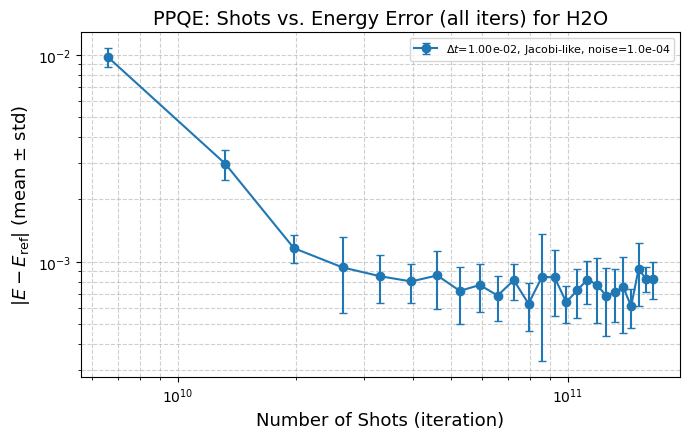

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"
reference_energy = -75.59903648548807  # <-- Set your reference energy here

include_dt = [1.0e-2, 1.0e-1]  # or None for all
include_update_types = ['jl']  # or None for all
include_noise_factors = [1.0e-4]  # or None for all

# Color palette for dt values (expand as needed)
color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
all_update_types = ['jl', 'tlr', 'tlrim']
if include_update_types is None:
    plot_update_types = all_update_types
else:
    plot_update_types = [ut for ut in include_update_types if ut in all_update_types]

dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")
noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")

# --- Gather all files ---
all_files = glob.glob(f"ppqe_noisy_runs_data/ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize data: {dt: {update_type: {noise: {iter: [(nshots, |E-Eref|), ...]}}}} ---
data = defaultdict(lambda: {ut: defaultdict(lambda: defaultdict(list)) for ut in plot_update_types})

for fname in all_files:
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    noise_m = noise_pattern.search(fname)
    if not (dt_m and update_m and noise_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    noise = float(noise_m.group(1))
    if include_dt is not None and dt not in include_dt:
        continue
    if update_type not in plot_update_types:
        continue
    if include_noise_factors is not None and noise not in include_noise_factors:
        continue

    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    n_iters = arr.shape[0]
    for i in range(n_iters):
        E_i = arr[i, 1]
        nshots_i = arr[i, -1]
        dE_vs_ref = np.abs(E_i - reference_energy)
        data[dt][update_type][noise][i].append((nshots_i, dE_vs_ref))

# --- Assign a color to each dt ---
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

plt.figure(figsize=(7, 4.5))

for dt in dt_vals:
    color = dt_to_color[dt]
    for ut in plot_update_types:
        for noise in sorted(data[dt][ut].keys()):
            iter_dict = data[dt][ut][noise]
            n_iters = max(iter_dict.keys()) + 1 if iter_dict else 0
            nshots_means = []
            dE_means = []
            dE_stds = []
            for i in range(n_iters):
                pairs = iter_dict[i]
                if not pairs:
                    continue
                nshots_arr = np.array([p[0] for p in pairs])
                dE_arr = np.array([p[1] for p in pairs])
                nshots_mean = np.mean(nshots_arr)
                dE_mean = np.mean(dE_arr)
                dE_std = np.std(dE_arr)
                nshots_means.append(nshots_mean)
                dE_means.append(dE_mean)
                dE_stds.append(dE_std)
            if nshots_means:
                label = f"$\Delta t$={dt:.2e}, {update_types[ut]['label']}, noise={noise:.1e}"
                plt.errorbar(
                    nshots_means, dE_means,
                    # yerr=[np.zeros_like(dE_stds), dE_stds],  # Only upper error bars
                    yerr=[dE_stds, dE_stds],  # Only upper error bars
                    marker='o',
                    linestyle=update_types[ut]['linestyle'],
                    color=color,
                    label=label,
                    capsize=3
                )

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Shots (iteration)", fontsize=13)
plt.ylabel(r"$|E - E_{\rm ref}|$ (mean $\pm$ std)", fontsize=13)
plt.title(f"PPQE: Shots vs. Energy Error (all iters) for {sys_str.upper()}", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.legend(fontsize=8, loc='best', ncol=2)

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/shots_vs_dE_vs_ref_alliters_{sys_str}_color_dt.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

Saved figure as figures/shots_vs_dE_vs_ref_alliters_h2o_ppqe_vqe.pdf


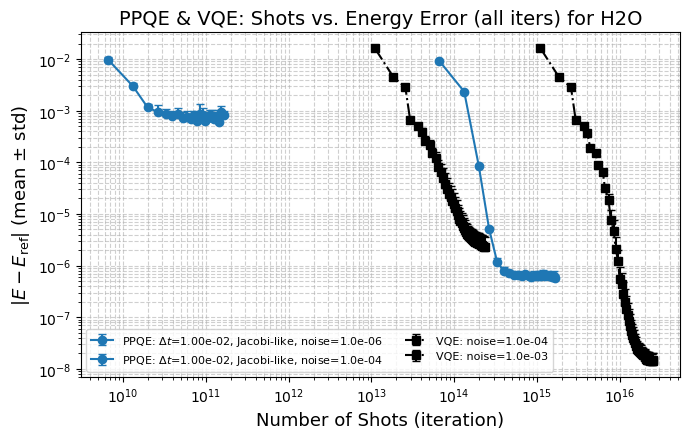

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"
reference_energy = -75.59903648548807  # <-- Set your reference energy here

# PPQE options
include_dt = [1.0e-2, 1.0e-1]  # or None for all
include_update_types = ['jl']  # or None for all
include_noise_factors = [1.0e-4, 1.0e-6]  # or None for all

# VQE options
include_vqe_noise_factors = [1.0e-3, 1.0e-4]  # or None for all

# Color palette for dt values (expand as needed)
color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]
vqe_color = 'black'

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
all_update_types = ['jl', 'tlr', 'tlrim']
if include_update_types is None:
    plot_update_types = all_update_types
else:
    plot_update_types = [ut for ut in include_update_types if ut in all_update_types]

dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")
noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
vqe_noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")

# --- Gather all PPQE files ---
all_files = glob.glob(f"ppqe_noisy_runs_data/ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize PPQE data: {dt: {update_type: {noise: {iter: [(nshots, |E-Eref|), ...]}}}} ---
data = defaultdict(lambda: {ut: defaultdict(lambda: defaultdict(list)) for ut in plot_update_types})

for fname in all_files:
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    noise_m = noise_pattern.search(fname)
    if not (dt_m and update_m and noise_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    noise = float(noise_m.group(1))
    if include_dt is not None and dt not in include_dt:
        continue
    if update_type not in plot_update_types:
        continue
    if include_noise_factors is not None and noise not in include_noise_factors:
        continue

    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    n_iters = arr.shape[0]
    for i in range(n_iters):
        E_i = arr[i, 1]
        nshots_i = arr[i, -1]
        dE_vs_ref = np.abs(E_i - reference_energy)
        data[dt][update_type][noise][i].append((nshots_i, dE_vs_ref))

# --- Gather all VQE files ---
vqe_files = glob.glob(f"vqe_noisy_runs_data/vqe_{sys_str}_pool_SD_gtol_*_ndiis_*_updt_BFGS_noise_*_r_*.dat")

# --- Organize VQE data: {noise: {iter: [(nshots, |E-Eref|), ...]}} ---
vqe_data = defaultdict(lambda: defaultdict(list))

for fname in vqe_files:
    noise_m = vqe_noise_pattern.search(fname)
    if not noise_m:
        continue
    noise = float(noise_m.group(1))
    if include_vqe_noise_factors is not None and noise not in include_vqe_noise_factors:
        continue

    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    n_iters = arr.shape[0]
    for i in range(n_iters):
        E_i = arr[i, 1]
        nshots_i = arr[i, -1]
        dE_vs_ref = np.abs(E_i - reference_energy)
        vqe_data[noise][i].append((nshots_i, dE_vs_ref))

# --- Assign a color to each dt ---
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

plt.figure(figsize=(7, 4.5))

# --- Plot PPQE ---
for dt in dt_vals:
    color = dt_to_color[dt]
    for ut in plot_update_types:
        for noise in sorted(data[dt][ut].keys()):
            iter_dict = data[dt][ut][noise]
            n_iters = max(iter_dict.keys()) + 1 if iter_dict else 0
            nshots_means = []
            dE_means = []
            dE_stds = []
            for i in range(n_iters):
                pairs = iter_dict[i]
                if not pairs:
                    continue
                nshots_arr = np.array([p[0] for p in pairs])
                dE_arr = np.array([p[1] for p in pairs])
                nshots_mean = np.mean(nshots_arr)
                dE_mean = np.mean(dE_arr)
                dE_std = np.std(dE_arr)
                nshots_means.append(nshots_mean)
                dE_means.append(dE_mean)
                dE_stds.append(dE_std)
            if nshots_means:
                label = f"PPQE: $\Delta t$={dt:.2e}, {update_types[ut]['label']}, noise={noise:.1e}"
                plt.errorbar(
                    nshots_means, dE_means,
                    yerr=[np.zeros_like(dE_stds), dE_stds],  # Only upper error bars
                    marker='o',
                    linestyle=update_types[ut]['linestyle'],
                    color=color,
                    label=label,
                    capsize=3
                )

# --- Plot VQE ---
for noise in sorted(vqe_data.keys()):
    iter_dict = vqe_data[noise]
    n_iters = max(iter_dict.keys()) + 1 if iter_dict else 0
    nshots_means = []
    dE_means = []
    dE_stds = []
    for i in range(n_iters):
        pairs = iter_dict[i]
        if not pairs:
            continue
        nshots_arr = np.array([p[0] for p in pairs])
        dE_arr = np.array([p[1] for p in pairs])
        nshots_mean = np.mean(nshots_arr)
        dE_mean = np.mean(dE_arr)
        dE_std = np.std(dE_arr)
        nshots_means.append(nshots_mean)
        dE_means.append(dE_mean)
        dE_stds.append(dE_std)
    if nshots_means:
        label = f"VQE: noise={noise:.1e}"
        plt.errorbar(
            nshots_means, dE_means,
            yerr=[np.zeros_like(dE_stds), dE_stds],  # Only upper error bars
            marker='s',
            linestyle='dashdot',
            color=vqe_color,
            label=label,
            capsize=3
        )

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Shots (iteration)", fontsize=13)
plt.ylabel(r"$|E - E_{\rm ref}|$ (mean $\pm$ std)", fontsize=13)
plt.title(f"PPQE & VQE: Shots vs. Energy Error (all iters) for {sys_str.upper()}", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.legend(fontsize=8, loc='best', ncol=2)

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/shots_vs_dE_vs_ref_alliters_{sys_str}_ppqe_vqe.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

Saved figure as figures/shots_vs_dE_vs_ref_alliters_h2o_ppqe_vqe.pdf


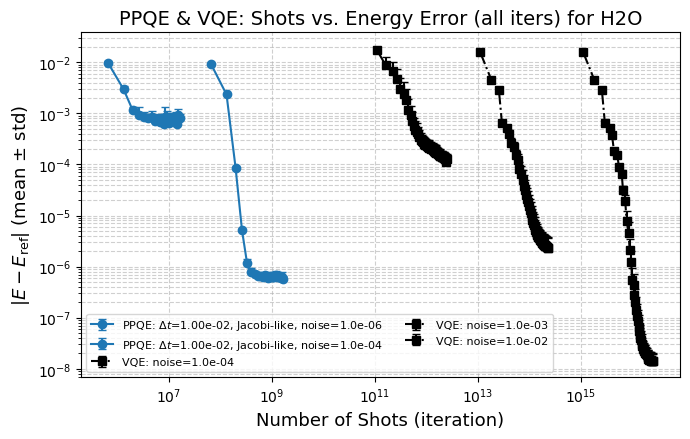

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"
reference_energy = -75.59903648548807  # <-- Set your reference energy here

# PPQE options
include_dt = [1.0e-2, 1.0e-1]  # or None for all
include_update_types = ['jl']  # or None for all
include_noise_factors = [1.0e-4, 1.0e-6]  # or None for all

# VQE options
include_vqe_noise_factors = [1.0e-2, 1.0e-3, 1.0e-4]  # or None for all

# Color palette for dt values (expand as needed)
color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]
vqe_color = 'black'

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
all_update_types = ['jl', 'tlr', 'tlrim']
if include_update_types is None:
    plot_update_types = all_update_types
else:
    plot_update_types = [ut for ut in include_update_types if ut in all_update_types]

dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")
noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
vqe_noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")

# --- Gather all PPQE files ---
all_files = glob.glob(f"ppqe_noisy_runs_data/ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize PPQE data: {dt: {update_type: {noise: {iter: [(nshots, |E-Eref|), ...]}}}} ---
data = defaultdict(lambda: {ut: defaultdict(lambda: defaultdict(list)) for ut in plot_update_types})

for fname in all_files:
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    noise_m = noise_pattern.search(fname)
    if not (dt_m and update_m and noise_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    noise = float(noise_m.group(1))
    if include_dt is not None and dt not in include_dt:
        continue
    if update_type not in plot_update_types:
        continue
    if include_noise_factors is not None and noise not in include_noise_factors:
        continue

    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    n_iters = arr.shape[0]
    for i in range(n_iters):
        E_i = arr[i, 1]
        nshots_i = arr[i, -1] * noise
        dE_vs_ref = np.abs(E_i - reference_energy)
        data[dt][update_type][noise][i].append((nshots_i, dE_vs_ref))

# --- Gather all VQE files ---
vqe_files = glob.glob(f"vqe_noisy_runs_data/vqe_{sys_str}_pool_SD_gtol_*_ndiis_*_updt_BFGS_noise_*_r_*.dat")

# --- Organize VQE data: {noise: {iter: [(nshots, |E-Eref|), ...]}} ---
vqe_data = defaultdict(lambda: defaultdict(list))

for fname in vqe_files:
    noise_m = vqe_noise_pattern.search(fname)
    if not noise_m:
        continue
    noise = float(noise_m.group(1))
    if include_vqe_noise_factors is not None and noise not in include_vqe_noise_factors:
        continue

    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    n_iters = arr.shape[0]
    for i in range(n_iters):
        E_i = arr[i, 1]
        nshots_i = arr[i, -1]
        dE_vs_ref = np.abs(E_i - reference_energy)
        vqe_data[noise][i].append((nshots_i, dE_vs_ref))

# --- Assign a color to each dt ---
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

plt.figure(figsize=(7, 4.5))

# --- Plot PPQE ---
for dt in dt_vals:
    color = dt_to_color[dt]
    for ut in plot_update_types:
        for noise in sorted(data[dt][ut].keys()):
            iter_dict = data[dt][ut][noise]
            n_iters = max(iter_dict.keys()) + 1 if iter_dict else 0
            nshots_means = []
            dE_means = []
            dE_stds = []
            for i in range(n_iters):
                pairs = iter_dict[i]
                if not pairs:
                    continue
                nshots_arr = np.array([p[0] for p in pairs])
                dE_arr = np.array([p[1] for p in pairs])
                nshots_mean = np.mean(nshots_arr)
                dE_mean = np.mean(dE_arr)
                dE_std = np.std(dE_arr)
                nshots_means.append(nshots_mean)
                dE_means.append(dE_mean)
                dE_stds.append(dE_std)
            if nshots_means:
                label = f"PPQE: $\Delta t$={dt:.2e}, {update_types[ut]['label']}, noise={noise:.1e}"
                plt.errorbar(
                    nshots_means, dE_means,
                    yerr=[np.zeros_like(dE_stds), dE_stds],  # Only upper error bars
                    marker='o',
                    linestyle=update_types[ut]['linestyle'],
                    color=color,
                    label=label,
                    capsize=3
                )

# --- Plot VQE ---
for noise in sorted(vqe_data.keys()):
    iter_dict = vqe_data[noise]
    n_iters = max(iter_dict.keys()) + 1 if iter_dict else 0
    nshots_means = []
    dE_means = []
    dE_stds = []
    for i in range(n_iters):
        pairs = iter_dict[i]
        if not pairs:
            continue
        nshots_arr = np.array([p[0] for p in pairs])
        dE_arr = np.array([p[1] for p in pairs])
        nshots_mean = np.mean(nshots_arr)
        dE_mean = np.mean(dE_arr)
        dE_std = np.std(dE_arr)
        nshots_means.append(nshots_mean)
        dE_means.append(dE_mean)
        dE_stds.append(dE_std)
    if nshots_means:
        label = f"VQE: noise={noise:.1e}"
        plt.errorbar(
            nshots_means, dE_means,
            yerr=[np.zeros_like(dE_stds), dE_stds],  # Only upper error bars
            marker='s',
            linestyle='dashdot',
            color=vqe_color,
            label=label,
            capsize=3
        )

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Shots (iteration)", fontsize=13)
plt.ylabel(r"$|E - E_{\rm ref}|$ (mean $\pm$ std)", fontsize=13)
plt.title(f"PPQE & VQE: Shots vs. Energy Error (all iters) for {sys_str.upper()}", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.legend(fontsize=8, loc='best', ncol=2)

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/shots_vs_dE_vs_ref_alliters_{sys_str}_ppqe_vqe.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

Saved figure as figures/noise_vs_dE_iter20_h2o_ppqe_lines.pdf


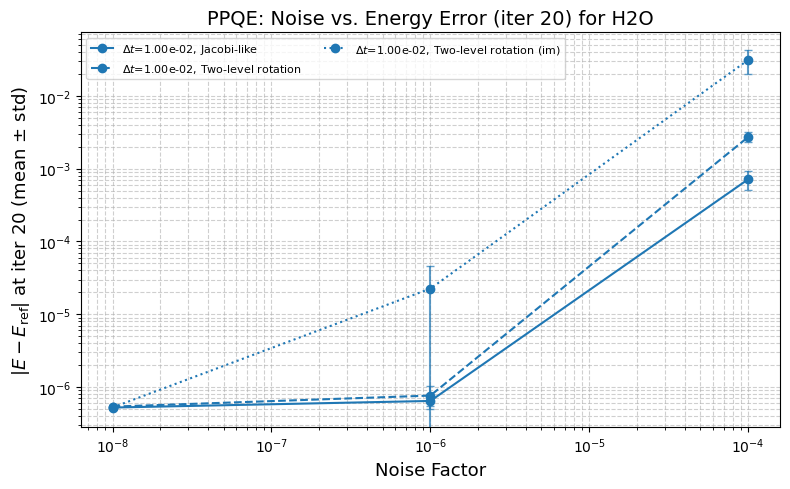

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"
reference_energy = -75.59903648548807
n_iter = 20
include_dt = [1.0e-2, 1.0e-1]
include_update_types = ['jl', 'tlr', 'tlrim']
include_noise_factors = [1.0e-8, 1.0e-6, 1.0e-4]

color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
all_update_types = ['jl', 'tlr', 'tlrim']
if include_update_types is None:
    plot_update_types = all_update_types
else:
    plot_update_types = [ut for ut in include_update_types if ut in all_update_types]

dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")
noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")

# --- Gather all PPQE files ---
all_files = glob.glob(f"ppqe_noisy_runs_data/ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")
# Structure: data[dt][update_type][noise] = list of (dE, nshots)
data = defaultdict(lambda: {ut: defaultdict(list) for ut in plot_update_types})

for fname in all_files:
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    noise_m = noise_pattern.search(fname)
    if not (dt_m and update_m and noise_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    noise = float(noise_m.group(1))
    if include_dt is not None and dt not in include_dt:
        continue
    if update_type not in plot_update_types:
        continue
    if include_noise_factors is not None and noise not in include_noise_factors:
        continue
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    if arr.shape[0] < n_iter:
        continue
    dE_n = np.abs(arr[n_iter-1, 1] - reference_energy)
    nshots_n = arr[n_iter-1, -1]
    data[dt][update_type][noise].append((dE_n, nshots_n))

# --- Plot: x=noise, y=avg dE, lines connect noise values for each (dt, update_type) ---
plt.figure(figsize=(8, 5))
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

for dt in dt_vals:
    color = dt_to_color[dt]
    for ut in plot_update_types:
        noise_vals = sorted(data[dt][ut].keys())
        if not noise_vals:
            continue
        avg_dEs = []
        std_dEs = []
        avg_nshots = []
        for noise in noise_vals:
            dEs = [x[0] for x in data[dt][ut][noise]]
            nshots = [x[1] for x in data[dt][ut][noise]]
            avg_dEs.append(np.mean(dEs))
            std_dEs.append(np.std(dEs))
            avg_nshots.append(np.mean(nshots))
        label = f"$\Delta t$={dt:.2e}, {update_types[ut]['label']}"
        plt.plot(noise_vals, avg_dEs, marker='o', linestyle=update_types[ut]['linestyle'],
                 color=color, label=label)
        plt.errorbar(noise_vals, avg_dEs, yerr=std_dEs, fmt='none', ecolor=color, capsize=3, alpha=0.7)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Noise Factor", fontsize=13)
plt.ylabel(r"$|E - E_{\rm ref}|$ at iter %d (mean $\pm$ std)" % n_iter, fontsize=13)
plt.title(f"PPQE: Noise vs. Energy Error (iter {n_iter}) for {sys_str.upper()}", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.legend(fontsize=8, loc='best', ncol=2)

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/noise_vs_dE_iter{n_iter}_{sys_str}_ppqe_lines.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

Saved figure as figures/shots_vs_dE_iter20_h2o_ppqe_vqe_lines.pdf


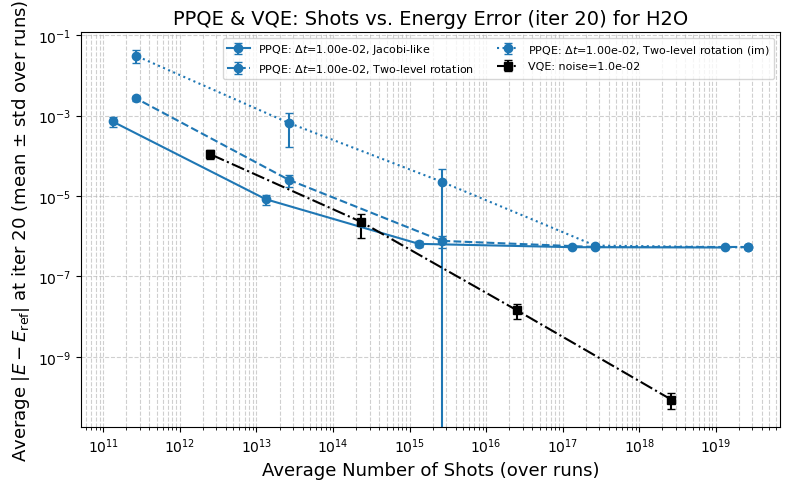

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"
reference_energy = -75.59903648548807
n_iter = 20  # Which iteration to analyze (1-based)
n_iter_vqe = 50  # Which iteration to analyze (1-based)
include_dt = [1.0e-2]
include_update_types = ['jl', 'tlr', 'tlrim']
include_noise_factors = [1.0e-8, 1.0e-7, 1.0e-6, 1.0e-5, 1.0e-4]
include_vqe_noise_factors = [1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2]

color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]
vqe_color = 'black'

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
all_update_types = ['jl', 'tlr', 'tlrim']
if include_update_types is None:
    plot_update_types = all_update_types
else:
    plot_update_types = [ut for ut in include_update_types if ut in all_update_types]

dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")
noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
r_pattern = re.compile(r"r_(\d+)")

vqe_noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
vqe_r_pattern = re.compile(r"r_(\d+)")

# --- Gather all PPQE files ---
all_files = glob.glob(f"ppqe_noisy_runs_data/ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")
data = defaultdict(lambda: {ut: defaultdict(lambda: defaultdict(list)) for ut in plot_update_types})

for fname in all_files:
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    noise_m = noise_pattern.search(fname)
    r_m = r_pattern.search(fname)
    if not (dt_m and update_m and noise_m and r_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    noise = float(noise_m.group(1))
    run = int(r_m.group(1))
    if include_dt is not None and dt not in include_dt:
        continue
    if update_type not in plot_update_types:
        continue
    if include_noise_factors is not None and noise not in include_noise_factors:
        continue
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    if arr.shape[0] < n_iter:
        continue
    dE_n = np.abs(arr[n_iter-1, 1] - reference_energy)
    nshots_n = arr[n_iter-1, -1]
    data[dt][update_type][noise][run].append((dE_n, nshots_n))

# --- Gather all VQE files ---
vqe_files = glob.glob(f"vqe_noisy_runs_data/vqe_{sys_str}_pool_SD_gtol_*_ndiis_*_updt_BFGS_noise_*_r_*.dat")
vqe_data = defaultdict(lambda: defaultdict(list))  # vqe_data[noise][run] = (dE, nshots)

for fname in vqe_files:
    noise_m = vqe_noise_pattern.search(fname)
    r_m = vqe_r_pattern.search(fname)
    if not (noise_m and r_m):
        continue
    noise = float(noise_m.group(1))
    run = int(r_m.group(1))
    if include_vqe_noise_factors is not None and noise not in include_vqe_noise_factors:
        continue
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    if arr.shape[0] < n_iter_vqe:
        continue
    dE_n = np.abs(arr[n_iter_vqe-1, 1] - reference_energy)
    nshots_n = arr[n_iter_vqe-1, -1]
    vqe_data[noise][run] = (dE_n, nshots_n)

# --- Plot both PPQE and VQE ---
plt.figure(figsize=(8, 5))
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

# --- Plot PPQE ---
for dt in dt_vals:
    color = dt_to_color[dt]
    for ut in plot_update_types:
        noise_vals = sorted(data[dt][ut].keys())
        if not noise_vals:
            continue
        avg_nshots_list = []
        std_nshots_list = []
        avg_dEs = []
        std_dEs = []
        for noise in noise_vals:
            runs = data[dt][ut][noise]
            dEs = [runs[run][0][0] for run in runs if runs[run]]
            nshots = [runs[run][0][1] for run in runs if runs[run]]
            if not dEs or not nshots:
                continue
            avg_dEs.append(np.mean(dEs))
            std_dEs.append(np.std(dEs))
            avg_nshots_list.append(np.mean(nshots))
            std_nshots_list.append(np.std(nshots))

        if avg_nshots_list:
            label = f"PPQE: $\Delta t$={dt:.2e}, {update_types[ut]['label']}"
            plt.errorbar(
                avg_nshots_list, 
                avg_dEs,
                # xerr=std_nshots_list, 
                yerr=std_dEs,
                marker='o',
                linestyle=update_types[ut]['linestyle'],
                color=color,
                label=label,
                capsize=3
            )

avg_nshots_list_vqe = []
std_nshots_list_vqe = []
avg_dEs_vqe = []
std_dEs_vqe = []

# --- Plot VQE ---
for noise in sorted(vqe_data.keys()):
    runs = vqe_data[noise]
    dEs = [runs[run][0] for run in runs if runs[run]]
    nshots = [runs[run][1] for run in runs if runs[run]]
    if not dEs or not nshots:
        continue
    avg_dE = np.mean(dEs)
    std_dE = np.std(dEs)
    avg_nshot = np.mean(nshots)
    std_nshot = np.std(nshots)
    label = f"VQE: noise={noise:.1e}"
    avg_dEs_vqe.append(np.mean(dEs))
    std_dEs_vqe.append(np.std(dEs))
    avg_nshots_list_vqe.append(np.mean(nshots))
    std_nshots_list_vqe.append(np.std(nshots))

plt.errorbar(
    avg_nshots_list_vqe, 
    avg_dEs_vqe,
    # xerr=[std_nshot], 
    yerr=std_dEs_vqe,
    marker='s',
    linestyle='dashdot',
    color=vqe_color,
    label=label,
    capsize=3
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Average Number of Shots (over runs)", fontsize=13)
plt.ylabel(r"Average $|E - E_{\rm ref}|$ at iter %d (mean $\pm$ std over runs)" % n_iter, fontsize=13)
plt.title(f"PPQE & VQE: Shots vs. Energy Error (iter {n_iter}) for {sys_str.upper()}", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.legend(fontsize=8, loc='best', ncol=2)

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/shots_vs_dE_iter{n_iter}_{sys_str}_ppqe_vqe_lines.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()